<a href="https://colab.research.google.com/github/aljoharas/datascience/blob/main/spotifyproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Collection

In [17]:
%env SPOTIPY_CLIENT_ID=091a90ce07be44b2b4bb6f6fcf08fd31
%env SPOTIPY_CLIENT_SECRET=3333569ba9d44fc48d0b4d1e422db526


env: SPOTIPY_CLIENT_ID=091a90ce07be44b2b4bb6f6fcf08fd31
env: SPOTIPY_CLIENT_SECRET=3333569ba9d44fc48d0b4d1e422db526


In [18]:
!pip install spotipy


In [19]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
#hide our api key for safety
auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)


In [20]:
import os
import requests


csv_urls = [
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-ae-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-au-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-br-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-by-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-ch-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-eg-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-gb-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-global-weekly-2025-09-18.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-hk-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-in-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-it-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-jp-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-kr-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-sa-weekly-2025-09-18.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-th-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-tr-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-tw-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-us-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-uy-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-ve-weekly-2025-08-07.csv",
]

for url in csv_urls:
    filename = os.path.join("/content", url.split("/")[-1])
    if not os.path.exists(filename):
        r = requests.get(url)
        if r.status_code == 200:
            with open(filename, "wb") as f:
                f.write(r.content)
        else:
            print(f"Failed to download {url} — status code {r.status_code}")

import glob
chart_files = glob.glob("/content/regional-*.csv")
print(f"Found {len(chart_files)} chart files")

Found 20 chart files


In [21]:
import time
import pandas as pd # Import pandas here
for f in chart_files:
    df = pd.read_csv(f)
    print(f"{f}: columns = {df.columns.tolist()}")

#filter out directories
chart_files = [f for f in chart_files if os.path.isfile(f)]

print(f"Found {len(chart_files)} CSV files")


dfs = [pd.read_csv(f) for f in chart_files]
all_artists = pd.concat([df['artist_names'] for df in dfs]).unique()

print(f"Total unique artists across all charts: {len(all_artists)}")

/content/regional-global-weekly-2025-09-18.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-tr-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-kr-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-in-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-ve-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-tw-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_c

In [22]:
import time
from spotipy.exceptions import SpotifyException
import requests
from requests.exceptions import ReadTimeout
import pandas as pd

artist_data = []
seen_ids = set()

for artist_name in all_artists:
    try:
        result = sp.search(q=f"artist:{artist_name}", type="artist", limit=1)
        if result['artists']['items']:
            a = result['artists']['items'][0]
            # skip if no genres or already seen
            if not a['genres'] or a['id'] in seen_ids:
                continue
            artist_data.append({
                "name": a['name'],
                "id": a['id'],
                "genres": a['genres'],
                "popularity": a['popularity']
            })
            seen_ids.add(a['id'])

        time.sleep(0.5)
    except (requests.exceptions.ConnectionError, SpotifyException, ReadTimeout) as e:
        print(f"Error fetching {artist_name}: {e}. Retrying in 5 seconds...")
        time.sleep(5)
        continue

#creating the dataframe
df_artists = pd.DataFrame(artist_data)

print(f"✅ Final dataset: {len(df_artists)} artists with non-empty genres")
display(df_artists)


Error fetching صابر الجميعي: HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5). Retrying in 5 seconds...
✅ Final dataset: 699 artists with non-empty genres


,name,id,genres,popularity
0,Sabrina Carpenter,74KM79TiuVKeVCqs8QtB0B,[pop],96
1,Artist Unknown,6gjAbs229sNHhSskJpQ2mG,[opera],24
2,Olivia Dean,00x1fYSGhdqScXBRpSj3DW,[pop soul],87
3,KATSEYE,3c0gDdb9lhnHGFtP4prQpn,[k-pop],87
4,Jimin,1oSPZhvZMIrWW5I41kPkkY,[k-pop],84
...,...,...,...,...
694,Florence + The Machine,1moxjboGR7GNWYIMWsRjgG,[baroque pop],81
695,Blood Orange,6LEeAFiJF8OuPx747e1wxR,[art pop],76
696,Katy Perry,6jJ0s89eD6GaHleKKya26X,[pop],87
697,Two Door Cinema Club,536BYVgOnRky0xjsPT96zl,"[indie, indie rock]",70


===== Step 1: Adding genre_count and categorizing artists =====
✅ genre_count and genre_category added.

Sample data:


,name,id,genres,popularity,genre_count,genre_category
0,Sabrina Carpenter,74KM79TiuVKeVCqs8QtB0B,[pop],96,1,single-genre
1,Artist Unknown,6gjAbs229sNHhSskJpQ2mG,[opera],24,1,single-genre
2,Olivia Dean,00x1fYSGhdqScXBRpSj3DW,[pop soul],87,1,single-genre
3,KATSEYE,3c0gDdb9lhnHGFtP4prQpn,[k-pop],87,1,single-genre
4,Jimin,1oSPZhvZMIrWW5I41kPkkY,[k-pop],84,1,single-genre


===== Step 2: Descriptive statistics by genre category =====
                count       mean        std  min   25%   50%   75%   max
genre_category                                                          
multi-genre     471.0  67.127389  12.171326  7.0  60.0  66.0  75.0  99.0
single-genre    228.0  63.223684  18.102935  0.0  50.0  66.0  77.0  99.0 

===== Step 3: Boxplot - Popularity by Genre Category =====


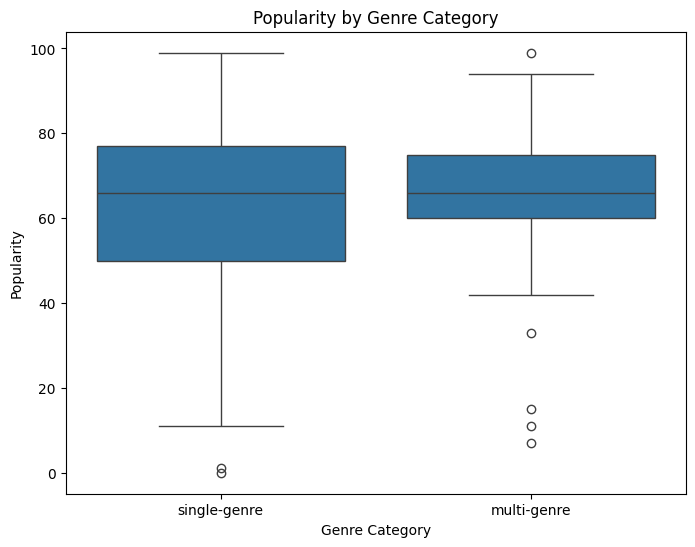

===== Step 4: Scatter plot - Popularity vs Number of Genres =====


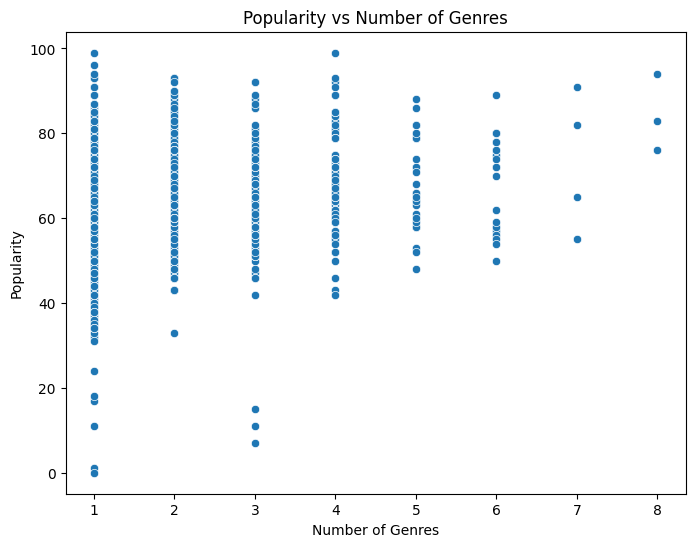

===== Step 5: Histogram of Artist Popularity =====


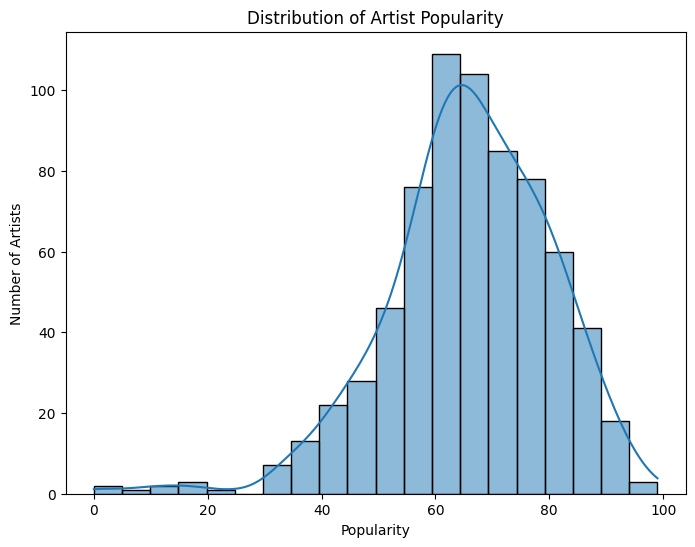

===== Step 6: Count of Single-Genre vs Multi-Genre Artists =====


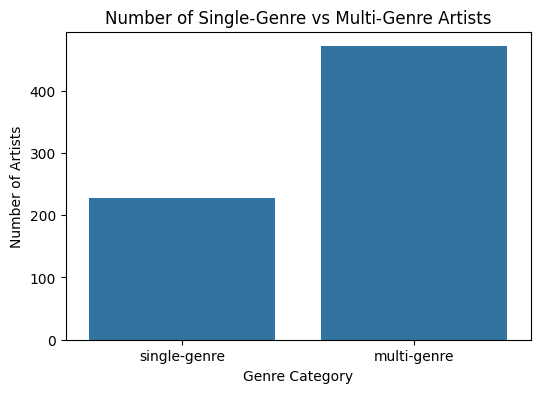

===== Step 7: Popularity vs Number of Genres (with Trend Line) =====


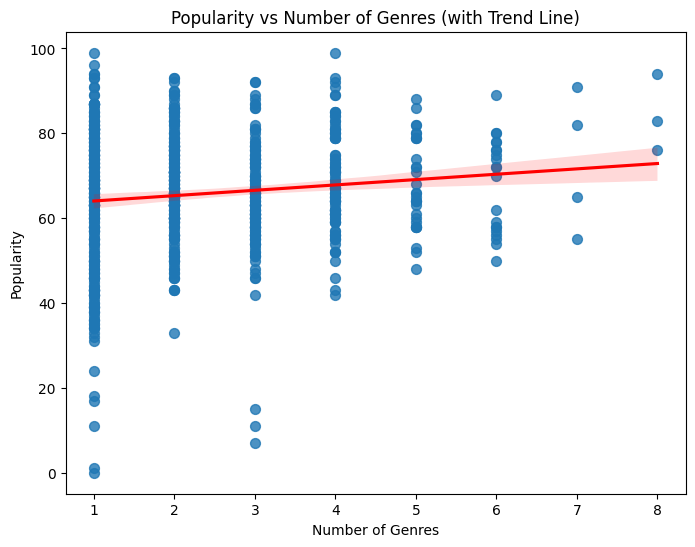

✅ All analysis and visualizations completed.


In [26]:
# =========================
# Full Analysis and Visualization
# =========================

print("===== Step 1: Adding genre_count and categorizing artists =====")
df_artists['genre_count'] = df_artists['genres'].apply(len)
df_artists['genre_category'] = df_artists['genre_count'].apply(lambda x: 'single-genre' if x == 1 else 'multi-genre')
print("✅ genre_count and genre_category added.")
print("\nSample data:")
display(df_artists.head())

# =========================
# Step 2: Descriptive statistics
# =========================
print("===== Step 2: Descriptive statistics by genre category =====")
stats = df_artists.groupby('genre_category')['popularity'].describe()
print(stats, "\n")

# =========================
# Step 3: Boxplot - Popularity by genre category
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

print("===== Step 3: Boxplot - Popularity by Genre Category =====")
plt.figure(figsize=(8,6))
sns.boxplot(x='genre_category', y='popularity', data=df_artists)
plt.title('Popularity by Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Popularity')
plt.show()

# =========================
# Step 4: Scatter plot - genre_count vs popularity
# =========================
print("===== Step 4: Scatter plot - Popularity vs Number of Genres =====")
plt.figure(figsize=(8,6))
sns.scatterplot(x='genre_count', y='popularity', data=df_artists)
plt.title('Popularity vs Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Popularity')
plt.show()

# =========================
# Step 5: Histogram of popularity
# =========================
print("===== Step 5: Histogram of Artist Popularity =====")
plt.figure(figsize=(8,6))
sns.histplot(df_artists['popularity'], bins=20, kde=True)
plt.title('Distribution of Artist Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Artists')
plt.show()

# =========================
# Step 6: Countplot of genre categories
# =========================
print("===== Step 6: Count of Single-Genre vs Multi-Genre Artists =====")
plt.figure(figsize=(6,4))
sns.countplot(x='genre_category', data=df_artists)
plt.title('Number of Single-Genre vs Multi-Genre Artists')
plt.xlabel('Genre Category')
plt.ylabel('Number of Artists')
plt.show()

# =========================
# Step 7: Scatter with regression line
# =========================
print("===== Step 7: Popularity vs Number of Genres (with Trend Line) =====")
plt.figure(figsize=(8,6))
sns.regplot(x='genre_count', y='popularity', data=df_artists, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Popularity vs Number of Genres (with Trend Line)')
plt.xlabel('Number of Genres')
plt.ylabel('Popularity')
plt.show()

print("✅ All analysis and visualizations completed.")
